In [313]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse, meanabs
import patsy
import statsmodels.tools.tools

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import lars_path
%matplotlib inline

In [314]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

# Load Data from CSV

In [5]:
leagues = pd.read_csv('leagues.csv')
leagues = leagues.drop(columns=['Unnamed: 0'])
leagues.index = leagues.Team

In [25]:
leagues['AttendPCT'] = leagues.AvgAttendance / leagues.Capacity

In [12]:
leagues.columns

Index(['Team', 'City', 'Capacity', 'Founded', 'Latitude', 'Longitude',
       'AvgAttendance', 'Games', '2018winPCT', 'Dist_close_team_in_league',
       'Sport', 'Venue', 'Teams_within_1_mi', 'Teams_within_10_mi',
       'Teams_within_25_mi', 'Teams_within_50_mi', 'pop2016', 'pop_dens'],
      dtype='object')

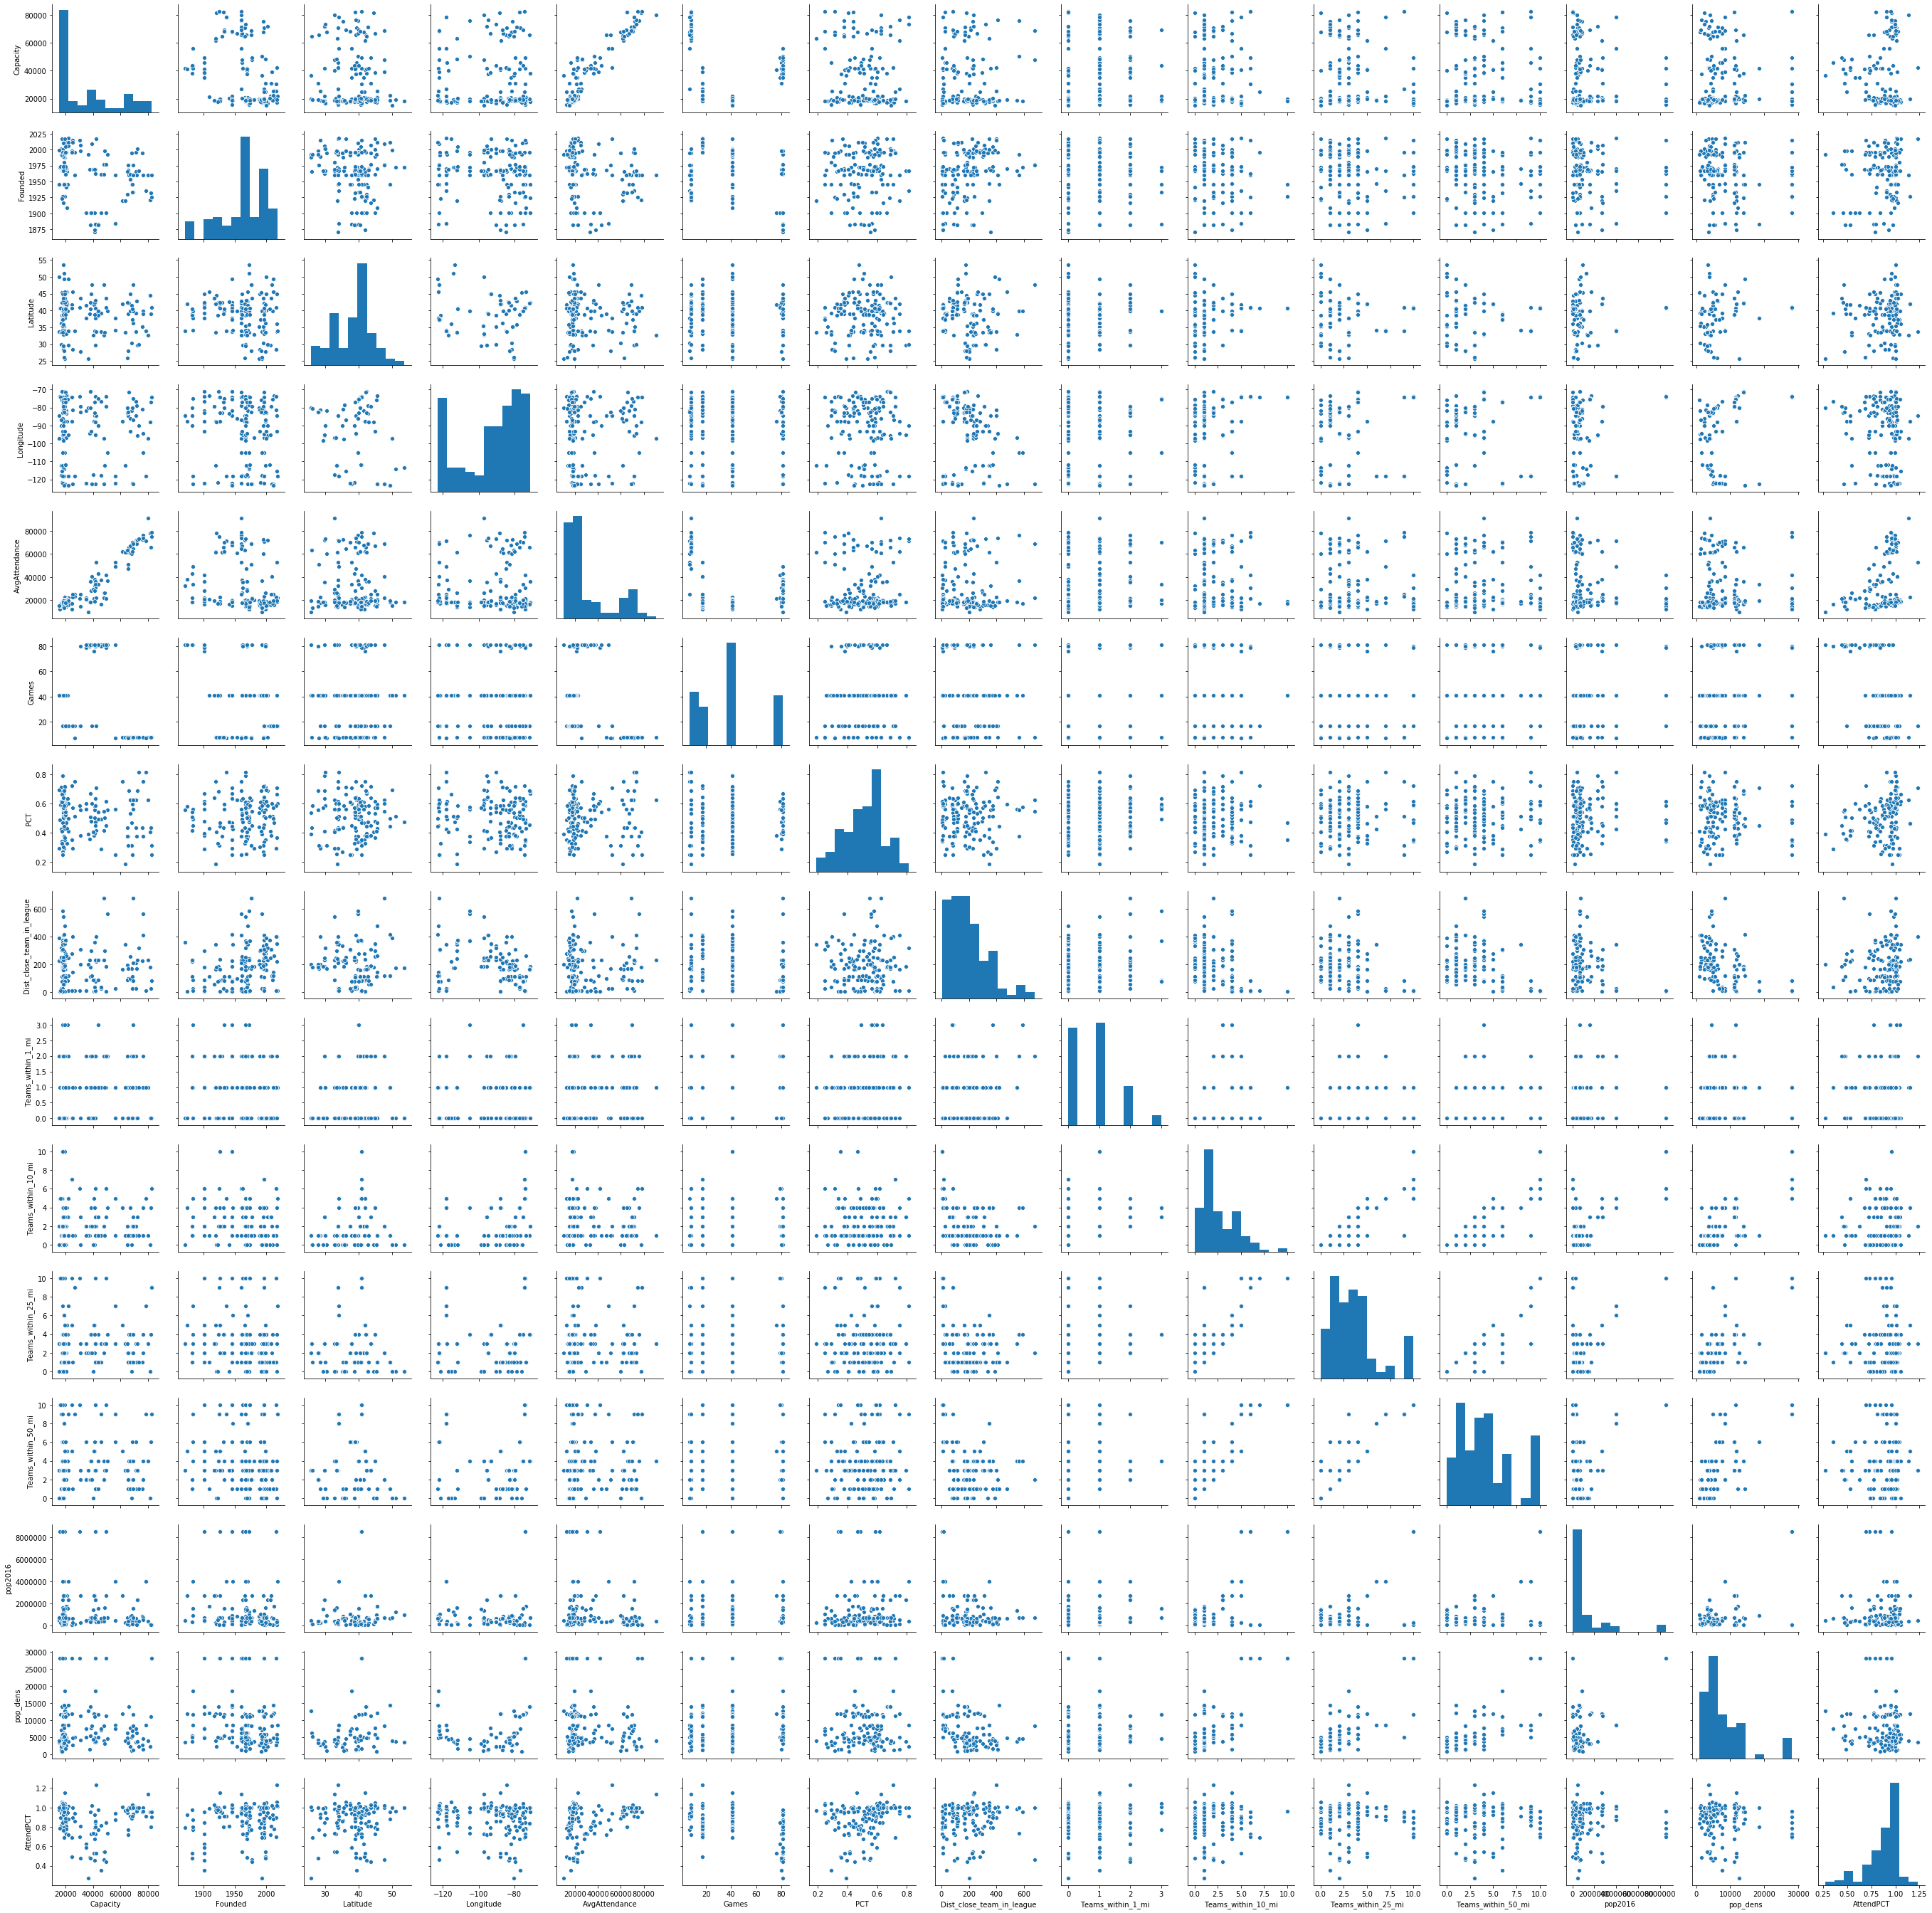

In [56]:
sns.pairplot(leagues)
plt.savefig('pairplot.png')

In [13]:
leagues.corr()['AvgAttendance'].sort_values(ascending=False)

AvgAttendance                1.000000
Capacity                     0.943512
Teams_within_1_mi            0.057205
Teams_within_10_mi           0.045580
Longitude                    0.036954
Teams_within_25_mi           0.022517
Teams_within_50_mi           0.021012
2018winPCT                   0.009791
Dist_close_team_in_league   -0.019746
pop_dens                    -0.027355
Latitude                    -0.057590
pop2016                     -0.113057
Founded                     -0.209940
Games                       -0.458555
Name: AvgAttendance, dtype: float64

In [14]:
leagues.corr()['AttendPCT'].sort_values(ascending=False)

KeyError: 'AttendPCT'

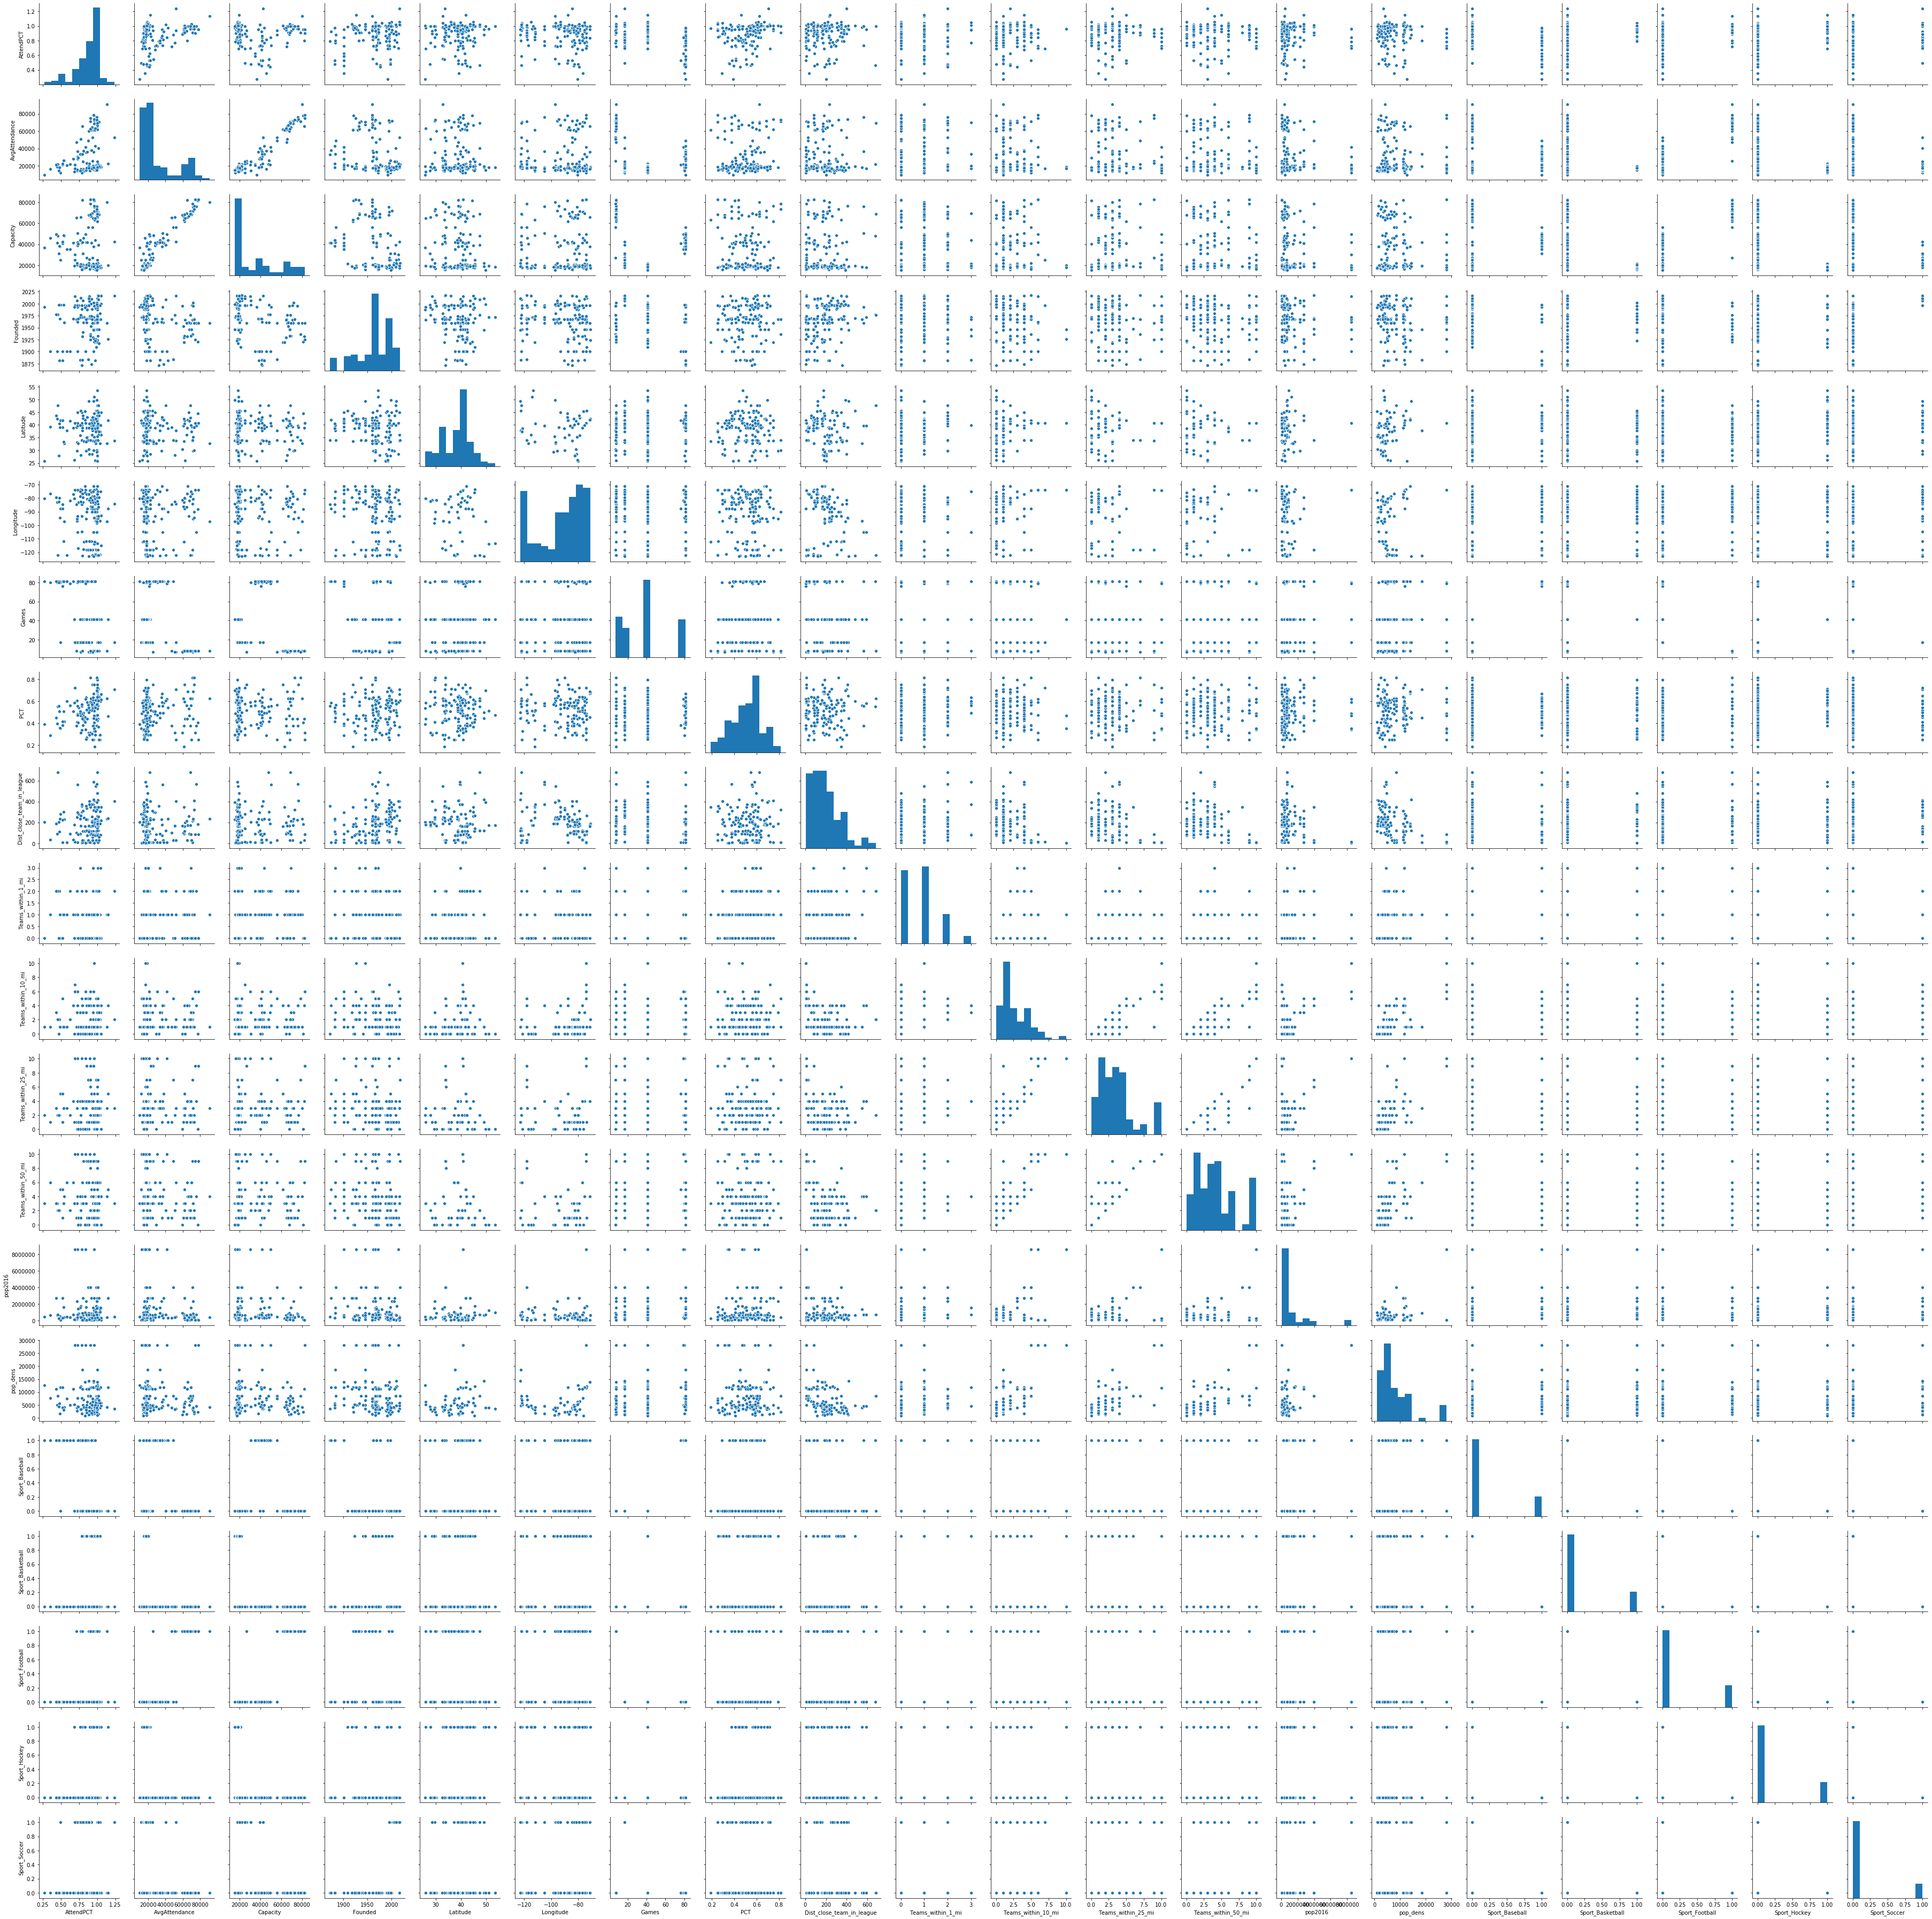

In [51]:
sns.pairplot(pd.get_dummies(leagues))

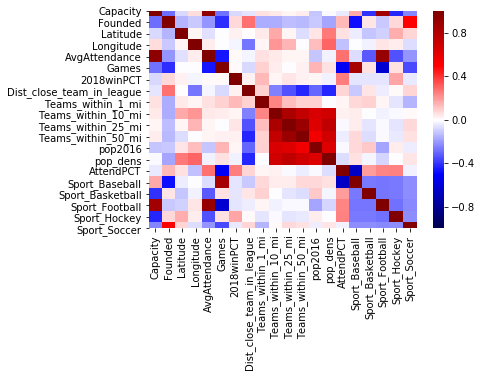

In [233]:
# example of a better corr matrix
sns.heatmap(pd.get_dummies(leagues, columns=['Sport']).corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
plt.savefig("heatmap.png")
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

# Prep data for statistical analysis

## Add dummies

In [235]:
leagues = pd.get_dummies(leagues, columns=['Sport'], drop_first=True)

In [236]:
leagues.columns

Index(['Team', 'City', 'Capacity', 'Founded', 'Latitude', 'Longitude',
       'AvgAttendance', 'Games', '2018winPCT', 'Dist_close_team_in_league',
       'Venue', 'Teams_within_1_mi', 'Teams_within_10_mi',
       'Teams_within_25_mi', 'Teams_within_50_mi', 'pop2016', 'pop_dens',
       'AttendPCT', 'Sport_Basketball', 'Sport_Football', 'Sport_Hockey',
       'Sport_Soccer'],
      dtype='object')

In [615]:
X = leagues.loc[:,[
    'Capacity',
    'Founded',
    'Latitude',
    'Longitude',
    'Games',
    '2018winPCT',
    'Dist_close_team_in_league',
    'Teams_within_1_mi',
    'Teams_within_10_mi',
    'Teams_within_25_mi',
    'Teams_within_50_mi',
    'pop2016',
    'pop_dens',
    'Sport_Basketball',
    'Sport_Football',
    'Sport_Hockey',
    'Sport_Soccer'
]]

## y = AvgAttendance

In [257]:
#Examine attendance
y = leagues['AvgAttendance']

## y = AttendPCT

In [746]:
#Examine attendance percentage
y = leagues['AttendPCT']

## Chicago Fire

In [672]:
fire = X.loc['Chicago Fire FC']

In [673]:
fire.Capacity = 61500
fire.Latitude = 41.863
fire.Longitude = -87.617
fire[5] = 16/34
fire.Teams_within_1_mi = 1
fire.Teams_within_10_mi = 5
fire.Teams_within_25_mi = 5
fire.Teams_within_50_mi = 5 

/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [674]:
fire

Capacity                     61500.000000
Founded                       1998.000000
Latitude                        41.863000
Longitude                      -87.617000
Games                           17.000000
2018winPCT                       0.470588
Dist_close_team_in_league      279.700000
Teams_within_1_mi                1.000000
Teams_within_10_mi               5.000000
Teams_within_25_mi               5.000000
Teams_within_50_mi               5.000000
pop2016                      50000.000000
pop_dens                     11883.000000
Sport_Basketball                 0.000000
Sport_Football                   0.000000
Sport_Hockey                     0.000000
Sport_Soccer                     1.000000
Name: Chicago Fire FC, dtype: float64

# Sklearn linear

## Holdout

In [519]:
# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=8)

## Vanilla Linear regression

In [418]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

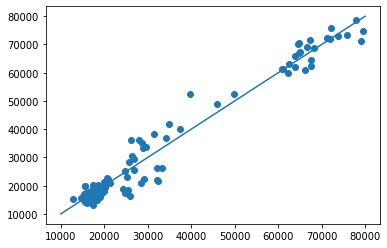

In [419]:
plt.scatter(lr.predict(X_train), y_train)
plt.plot([10000,80000],[10000,80000])

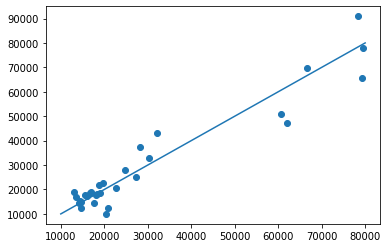

In [420]:
plt.scatter(lr.predict(X_test), y_test)
plt.plot([10000,80000],[10000,80000])

In [427]:
print('r^2: ',r2_score(lr.predict(X_test),y_test))
print('RSME: ',np.sqrt(mean_squared_error(lr.predict(X_test),y_test)))
print('MAE: ',mae(lr.predict(X_test),y_test))

r^2:  0.9151593985793285
RSME:  6257.028859839552
MAE:  4494.859692153381


## Single Train-validate split

In [259]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=3)

In [260]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

#X_train_scaled = scaler.fit_transform(X_train.values)
X_tr_scaled = scaler.fit_transform(X_tr.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_tr_poly = poly.fit_transform(X_tr.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [261]:
#validate

lm.fit(X_tr, y_tr)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_tr_scaled, y_tr)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_tr_poly, y_tr)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.966
Ridge Regression val R^2: 0.960
Degree 2 polynomial regression val R^2: -2.250


^Polynomial doesn't seem like the way.

In [262]:
#lm.fit(X_train,y_train)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.913


## Cross validation with KFold

In [275]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [498]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=73)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.9710326001756554, 0.9793472303787932, 0.9100499405827241, 0.877128894815161, 0.9111888082536972]
Ridge scores:  [0.9714501093197381, 0.9786821069915728, 0.9078886578007314, 0.8668864983065515, 0.9107816264278848]
Lasso scores:  [0.9749530964632452, 0.9765162925307876, 0.9176219294356885, 0.8552038460509553, 0.9075483423332499] 

Simple mean r^2: 0.930 +- 0.039
Ridge mean r^2: 0.927 +- 0.042
Lasso mean r^2: 0.926 +- 0.046

Simple mean rmse: 4710.611 +- 1122.734
Ridge mean rmse: 4780.789 +- 1187.018
Lasso mean rmse: 4767.733 +- 1190.023

Simple mean mae: 3416.920 +- 663.547
Ridge mean mae: 3495.529 +- 730.602
Lasso mean mae: 3399.645 +- 688.124


## Test

In [345]:
lr.fit(X_train, y_train)
print(f'Linear Regression test R^2: {r2_score(lr.predict(X_test), y_test):.3f}')
print(f'Linear Regression test RSME: {np.mean(np.sqrt(mean_squared_error(lr.predict(X_test), y_test))):.3f}')
print(f'Linear Regression test MAE: {np.mean(mae(lr.predict(X_test), y_test)):.3f}')

Linear Regression test R^2: 0.915
Linear Regression test RSME: 6257.029
Linear Regression test MAE: 4494.860


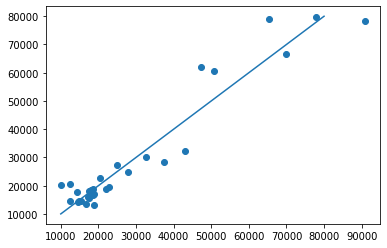

In [338]:
plt.scatter(y_test,lr.predict(X_test))
plt.plot([10000,80000],[10000,80000])

### Another CV

In [428]:
kf = KFold(n_splits=5, shuffle=True, random_state = 20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)

lr = LinearRegression()
lr_ridge = Ridge(alpha=1)
lr_lasso = Lasso(alpha=60)

In [429]:
kf = KFold(n_splits=5, shuffle=True, random_state = 20)

lr_r2 = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')
ridge_r2 = cross_val_score(lr_ridge, X_train_scaled, y_train, cv=kf, scoring='r2')
lasso_r2 = cross_val_score(lr_lasso, X_train_scaled, y_train, cv=kf, scoring='r2')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')


lr_rmse = np.sqrt(-1*cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
ridge_rmse = np.sqrt(-1*cross_val_score(lr_ridge, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error'))
lasso_rmse = np.sqrt(-1*cross_val_score(lr_lasso, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error'))

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')


lr_mae = -1*cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
ridge_mae = -1*cross_val_score(lr_ridge, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')
lasso_mae = -1*cross_val_score(lr_lasso, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')

Simple mean r^2: 0.930 +- 0.039
Ridge mean r^2: 0.918 +- 0.059
Lasso mean r^2: 0.926 +- 0.045

Simple mean rmse: 4710.611 +- 1122.734
Ridge mean rmse: 4961.886 +- 1440.606
Lasso mean rmse: 4769.506 +- 1184.942

Simple mean mae: 3416.920 +- 663.547
Ridge mean mae: 3542.827 +- 803.073
Lasso mean mae: 3406.346 +- 684.055


## Tune hyperparameters

### Examine Lasso parameter

#### Tune Lasso alpha

In [463]:
#alphalist = 10**(np.linspace(-1,1,200))
#alphalist = 10**(np.linspace(-1,2,200))
alphalist = np.linspace(60,80,200)

err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mae(y_val, val_set_pred)

alpha range: 0.1 to 10.0
Min MAE: 2150.336 at alpha: 0.1


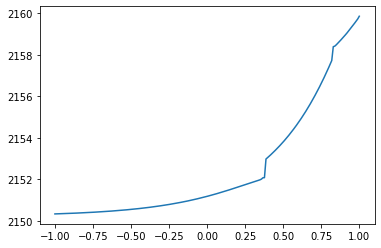

In [460]:
plt.plot(np.log10(alphalist), err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

alpha range: 0.1 to 100.0
Min MAE: 2129.415 at alpha: 73.16807143427192


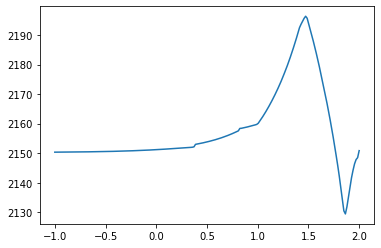

In [462]:
plt.plot(np.log10(alphalist), err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

alpha range: 60.0 to 80.0
Min MAE: 2129.250 at alpha: 73.66834170854271


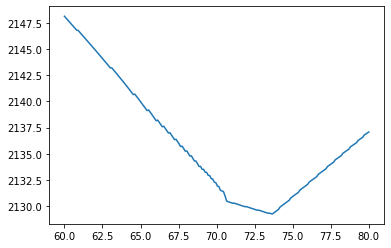

In [464]:
plt.plot(alphalist, err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

Min for lasso alpha is 73.6

In [508]:
std = StandardScaler()
X_tr_std = std.fit_transform(X_train.values)

lasso_model = Lasso(alpha = 59)
lasso_model.fit(X_tr_std, y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('Capacity', 19416.698719254167),
 ('Founded', -888.3426937907319),
 ('Latitude', -268.170935356099),
 ('Longitude', -505.5042300387461),
 ('Games', -4879.375671085686),
 ('2018winPCT', 1185.5633554163749),
 ('Dist_close_team_in_league', 0.0),
 ('Teams_within_1_mi', -362.63057327369415),
 ('Teams_within_10_mi', 475.43213280315916),
 ('Teams_within_25_mi', 363.97197243253254),
 ('Teams_within_50_mi', -924.8684870785058),
 ('pop2016', 132.49528848593891),
 ('pop_dens', 131.14883706030216),
 ('Sport_Basketball', 2007.2653735481504),
 ('Sport_Football', 0.0),
 ('Sport_Hockey', 1714.6707185371463),
 ('Sport_Soccer', -0.0)]

### Examine Ridge

#### Tune Ridge alpha

In [496]:
#alphalist = 10**(np.linspace(-5,5,200))
#alphalist = 10**(np.linspace(-10,5,200))
alphalist = 10**(np.linspace(-2.5,-2.25,100))


err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mae(y_val, val_set_pred)

alpha range: 1e-05 to 100000.0
Min MAE: 2133.902 at alpha: 0.004605922041145108


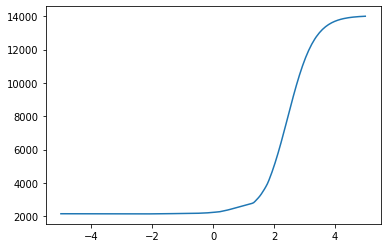

In [477]:
plt.plot(np.log10(alphalist), err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

alpha range: 1e-10 to 100000.0
Min MAE: 2134.034 at alpha: 0.00410265810582719


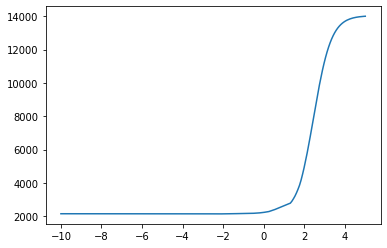

In [480]:
plt.plot(np.log10(alphalist), err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

alpha range: 0.0031622776601683794 to 0.005623413251903491
Min MAE: 2133.886 at alpha: 0.0046686564745964335


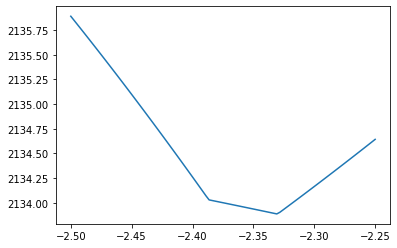

In [497]:
plt.plot(np.log10(alphalist), err_vec_val)
print(f'alpha range: {alphalist[0]} to {alphalist[-1]}')
print(f'Min MAE: {np.min(err_vec_val):.3f} at alpha: {alphalist[np.argmin(err_vec_val)]}')

min of alpha is .00466

In [507]:
std = StandardScaler()
X_tr_std = std.fit_transform(X_train.values)

ridge_model = Ridge(alpha = .00466)
ridge_model.fit(X_tr_std, y_train)
list(zip(X_train.columns, ridge_model.coef_))

[('Capacity', 20370.15635774111),
 ('Founded', -1215.0800302106727),
 ('Latitude', -415.03489285411365),
 ('Longitude', -753.4051968700761),
 ('Games', 27298.709943161848),
 ('2018winPCT', 1198.3329572730684),
 ('Dist_close_team_in_league', -209.53468602481905),
 ('Teams_within_1_mi', -551.5450445794838),
 ('Teams_within_10_mi', 483.4441301044792),
 ('Teams_within_25_mi', 1436.6592929758372),
 ('Teams_within_50_mi', -2034.3447109788892),
 ('pop2016', 244.94311496666535),
 ('pop_dens', 97.098690966956),
 ('Sport_Basketball', 24796.082835279638),
 ('Sport_Football', 38770.40832071005),
 ('Sport_Hockey', 21218.898841855917),
 ('Sport_Soccer', 31511.841755672795)]

In [499]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

StandardScaler(copy=True, with_mean=True, with_std=True)

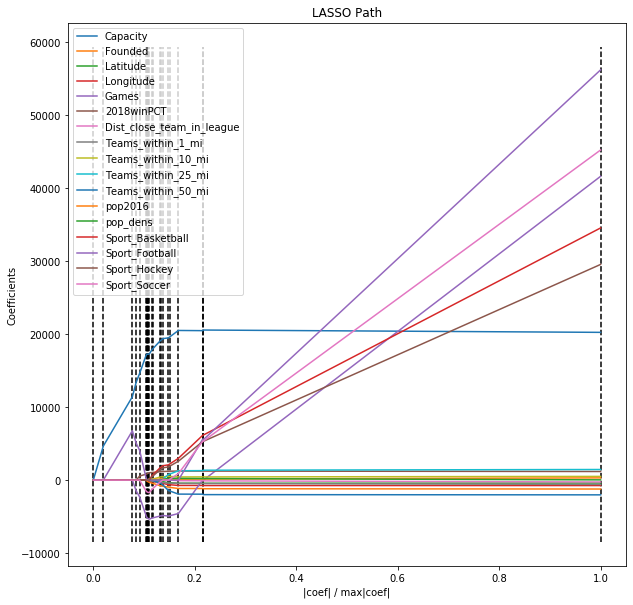

In [502]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

## Drop so parameters

### First pass

In [760]:
X_train_prime = X_train.copy()

In [511]:
drop_para = [
    #'Capacity',
    #'Founded',
    #'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    #'Teams_within_1_mi',
    #'Teams_within_10_mi',
    #'Teams_within_25_mi',
    #'Teams_within_50_mi',
    #'pop2016',
    #'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    'Sport_Soccer'
]

In [513]:
X_train = X_train.drop(drop_para, axis=1)

In [275]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [514]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=73)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.9743020484286885, 0.9768970329555121, 0.9164572546096963, 0.8919381393257333, 0.9175182896659715]
Ridge scores:  [0.9742981522653754, 0.9768980687545861, 0.9164641391667467, 0.8919292155023525, 0.9175782436326904]
Lasso scores:  [0.9750423079772025, 0.976516711637385, 0.9176212940352781, 0.893741911610542, 0.9191269631550283] 

Simple mean r^2: 0.935 +- 0.034
Ridge mean r^2: 0.935 +- 0.034
Lasso mean r^2: 0.936 +- 0.033

Simple mean rmse: 4554.027 +- 990.560
Ridge mean rmse: 4553.758 +- 990.617
Lasso mean rmse: 4523.430 +- 976.941

Simple mean mae: 3293.086 +- 582.124
Ridge mean mae: 3292.905 +- 582.002
Lasso mean mae: 3218.805 +- 550.949


#### Check Lasso

In [518]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(2,3,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 143.14589375234786


[('Capacity', 19224.51912106073),
 ('Founded', -674.9236689374192),
 ('Latitude', -61.059771701053656),
 ('Longitude', -256.5593101524892),
 ('Games', -4709.780885947768),
 ('2018winPCT', 1084.0182627806637),
 ('Teams_within_1_mi', -202.67866750750267),
 ('Teams_within_10_mi', 86.11150169482221),
 ('Teams_within_25_mi', 0.0),
 ('Teams_within_50_mi', -76.0799902270087),
 ('pop2016', 80.66391060228054),
 ('pop_dens', 0.0),
 ('Sport_Basketball', 1792.110314071318),
 ('Sport_Hockey', 1495.9304733217482)]

### Second pass

In [521]:
X_train = X_train_prime.copy()

In [522]:
drop_para = [
    #'Capacity',
    #'Founded',
    #'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    #'Teams_within_1_mi',
    #'Teams_within_10_mi',
    'Teams_within_25_mi',
    #'Teams_within_50_mi',
    #'pop2016',
    'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    'Sport_Soccer'
]

In [523]:
X_train = X_train.drop(drop_para, axis=1)

In [524]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [525]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=73)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.9547060403599741, 0.976785707130227, 0.9764036655682758, 0.973147375941074, 0.944444291172244, 0.8180188507826236, 0.901069568084169, 0.8961367844504544, 0.8705302989984154, 0.9635206347029479]
Ridge scores:  [0.954697568088866, 0.9767852659924564, 0.976406492588083, 0.9731416939563916, 0.9444597669455391, 0.8180254469890621, 0.9010444725106588, 0.8961501228733143, 0.8706442244223646, 0.963534070131173]
Lasso scores:  [0.9573781082399735, 0.9776357293728417, 0.9756666344155238, 0.9746408557369742, 0.9484225814618934, 0.8095164849514512, 0.8883124849592968, 0.8989119335259544, 0.8993769843125794, 0.9637434587864464] 

Simple mean r^2: 0.927 +- 0.051
Ridge mean r^2: 0.927 +- 0.051
Lasso mean r^2: 0.929 +- 0.052

Simple mean rmse: 4273.177 +- 1318.636
Ridge mean rmse: 4272.992 +- 1318.678
Lasso mean rmse: 4243.625 +- 1400.756

Simple mean mae: 3197.329 +- 906.723
Ridge mean mae: 3197.287 +- 906.839
Lasso mean mae: 3118.452 +- 993.026


#### Check Lasso

In [528]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

#alphavec = 10**np.linspace(-5,5,200)
#alphavec = 10**np.linspace(2,3,200)
alphavec = np.linspace(200,250,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 210.0502512562814


[('Capacity', 19017.216656861834),
 ('Founded', -570.725434854915),
 ('Latitude', -0.0),
 ('Longitude', -148.86291600738497),
 ('Games', -4615.046849418321),
 ('2018winPCT', 1006.5412337739789),
 ('Teams_within_1_mi', -94.98031373538568),
 ('Teams_within_10_mi', 0.0),
 ('Teams_within_50_mi', -0.0),
 ('pop2016', 6.495892263208148),
 ('Sport_Basketball', 1574.1758595577473),
 ('Sport_Hockey', 1297.2280095134304)]

### Third pass

In [529]:
X_train = X_train_prime.copy()

In [530]:
drop_para = [
    #'Capacity',
    #'Founded',
    'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    #'Teams_within_1_mi',
    'Teams_within_10_mi',
    'Teams_within_25_mi',
    'Teams_within_50_mi',
    #'pop2016',
    'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    'Sport_Soccer'
]

In [531]:
X_train = X_train.drop(drop_para, axis=1)

In [532]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [533]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=200)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.9600310748699928, 0.9800488018861554, 0.9766167724085665, 0.9756999805154131, 0.9405731123223541, 0.8205526940116133, 0.8947356432829041, 0.9006003977627738, 0.8890912016515544, 0.9677634982464502]
Ridge scores:  [0.9600224929069091, 0.9800470700527499, 0.9766216374136274, 0.9756974971807669, 0.940587928026649, 0.8205585548245611, 0.8947056194190149, 0.9006022992944639, 0.8891920485398793, 0.9677759026053214]
Lasso scores:  [0.9596252003124268, 0.9780562529639485, 0.973994928854044, 0.9761222553914004, 0.9580113122553872, 0.81103156291926, 0.8825708795252952, 0.9035318083150826, 0.9143103124342018, 0.960380843149146] 

Simple mean r^2: 0.931 +- 0.050
Ridge mean r^2: 0.931 +- 0.050
Lasso mean r^2: 0.932 +- 0.051

Simple mean rmse: 4184.932 +- 1392.339
Ridge mean rmse: 4184.780 +- 1392.441
Lasso mean rmse: 4183.954 +- 1402.045

Simple mean mae: 3059.730 +- 1007.537
Ridge mean mae: 3059.729 +- 1007.725
Lasso mean mae: 3077.145 +- 1001.992


#### Check Lasso

In [536]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

#alphavec = 10**np.linspace(-5,5,200)
#alphavec = 10**np.linspace(1,2.5,200)
alphavec = np.linspace(50,120,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 95.7286432160804


[('Capacity', 19416.355511653874),
 ('Founded', -712.1957070351359),
 ('Longitude', -316.3181941981173),
 ('Games', -4757.574380001832),
 ('2018winPCT', 1135.5426353032221),
 ('Teams_within_1_mi', -267.2635152244678),
 ('pop2016', 152.5790014880926),
 ('Sport_Basketball', 1982.7680610691573),
 ('Sport_Hockey', 1661.3723041062249)]

#### Check Ridge

In [538]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-5,-5,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)
ridge_model.fit(X_tr_sc, y_train)

print(f'alpha: {ridge_model.alpha_}')

list(zip(X_train.columns, ridge_model.coef_))

alpha: 1e-05


/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[('Capacity', 19747.48776464811),
 ('Founded', -831.869119095842),
 ('Longitude', -456.5025248752056),
 ('Games', -4877.8432758804975),
 ('2018winPCT', 1243.665065875382),
 ('Teams_within_1_mi', -411.289021408631),
 ('pop2016', 274.92655161992525),
 ('Sport_Basketball', 2323.000620425209),
 ('Sport_Hockey', 1964.7950450505623)]

### Fourth pass

In [620]:
X_train = X_train_prime.copy()

In [621]:
drop_para = [
    #'Capacity',
    #'Founded',
    'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    'Teams_within_1_mi',
    'Teams_within_10_mi',
    'Teams_within_25_mi',
    'Teams_within_50_mi',
    'pop2016',
    'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    'Sport_Soccer'
]

In [622]:
X_train = X_train.drop(drop_para, axis=1)

In [623]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [629]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00001)
    lr_lasso = Lasso(alpha=74)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.9613957151800725, 0.978298590440406, 0.9753124462301728, 0.9772797536368782, 0.9439412742092118, 0.8264421995871342, 0.8910557655443619, 0.9027126056414281, 0.9416643717739985, 0.9681067019087174]
Ridge scores:  [0.96139569482132, 0.9782985893416984, 0.9753124576965376, 0.9772797440233736, 0.9439413017655852, 0.8264422275327109, 0.8910557063162182, 0.9027126104701666, 0.9416644728245006, 0.9681067272879322]
Lasso scores:  [0.9614390613363195, 0.9785280505081063, 0.9749507884059425, 0.9773170504510212, 0.9501763268541115, 0.8209719659452394, 0.888250733586597, 0.9036620014548471, 0.9438690872419634, 0.9656779759465144] 

Simple mean r^2: 0.937 +- 0.047
Ridge mean r^2: 0.937 +- 0.047
Lasso mean r^2: 0.936 +- 0.048

Simple mean rmse: 4109.387 +- 1456.766
Ridge mean rmse: 4109.386 +- 1456.766
Lasso mean rmse: 4104.019 +- 1457.174

Simple mean mae: 3036.206 +- 1090.000
Ridge mean mae: 3036.206 +- 1090.000
Lasso mean mae: 3024.270 +- 1088.565


In [630]:
list(zip(X_train.columns, lr.coef_))

[('Capacity', 0.9608034359260467),
 ('Founded', -10.85754484231573),
 ('Longitude', -21.258060243444),
 ('Games', -182.2683179463875),
 ('2018winPCT', 8447.708748073166),
 ('Sport_Basketball', 5378.671788449268),
 ('Sport_Hockey', 5540.178693096718)]

#### Check Lasso

In [628]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

#alphavec = 10**np.linspace(-5,5,200)
#alphavec = 10**np.linspace(1,2.5,200)
alphavec = np.linspace(50,120,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 74.2713567839196


[('Capacity', 19432.747873517834),
 ('Founded', -738.6601510547072),
 ('Longitude', -334.10812203029633),
 ('Games', -4791.759929044625),
 ('2018winPCT', 1131.7952145437807),
 ('Sport_Basketball', 2024.2381927035024),
 ('Sport_Hockey', 1718.680423872088)]

#### Check Ridge

In [538]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-5,-5,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)
ridge_model.fit(X_tr_sc, y_train)

print(f'alpha: {ridge_model.alpha_}')

list(zip(X_train.columns, ridge_model.coef_))

alpha: 1e-05


/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[('Capacity', 19747.48776464811),
 ('Founded', -831.869119095842),
 ('Longitude', -456.5025248752056),
 ('Games', -4877.8432758804975),
 ('2018winPCT', 1243.665065875382),
 ('Teams_within_1_mi', -411.289021408631),
 ('pop2016', 274.92655161992525),
 ('Sport_Basketball', 2323.000620425209),
 ('Sport_Hockey', 1964.7950450505623)]

## Test

In [548]:
X_test_prime = X_test.copy()

In [549]:
X_test = X_test.drop(drop_para, axis=1)

In [587]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Linear Regression test R^2: {r2_score(lr.predict(X_test), y_test):.3f}')
print(f'Linear Regression test RSME: {np.mean(np.sqrt(mean_squared_error(lr.predict(X_test), y_test))):.3f}')
print(f'Linear Regression test MAE: {np.mean(mae(lr.predict(X_test), y_test)):.3f}')

Linear Regression test R^2: 0.915
Linear Regression test RSME: 6158.175
Linear Regression test MAE: 4217.369


In [588]:
list(zip(X_train.columns, lr.coef_))

[('Capacity', 0.9516582356467498),
 ('Founded', -23.68075853250786),
 ('Longitude', -27.260533830246736),
 ('Games', -195.07831631759387),
 ('2018winPCT', 9033.889483361296),
 ('Teams_within_1_mi', -496.67833380319587),
 ('pop2016', 0.0001413973055332998),
 ('Sport_Basketball', 5364.746332064104),
 ('Sport_Hockey', 5309.004414627362)]

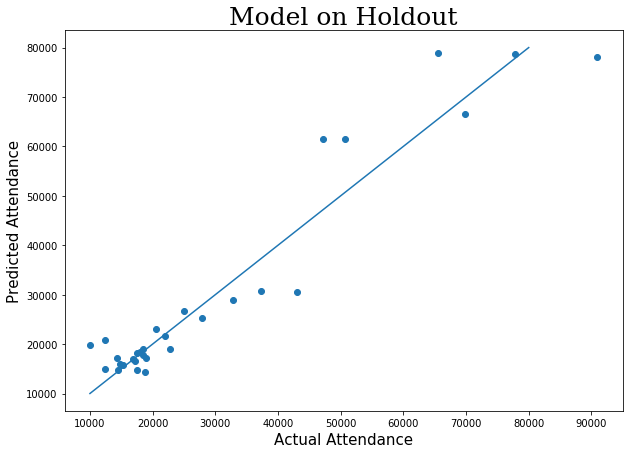

In [610]:
plt.figure(figsize=(10,7))
plt.scatter(y_test,lr.predict(X_test))
#plt.title('Model on Holdout', family='serif', fontsize=25)
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.plot([10000,80000],[10000,80000])
plt.savefig('final_test1.png')

In [559]:
fire

Capacity                     61500.000000
Founded                       1998.000000
Latitude                        41.863000
Longitude                      -87.617000
Games                           17.000000
2018winPCT                       0.470588
Dist_close_team_in_league      279.700000
Teams_within_1_mi                1.000000
Teams_within_10_mi               5.000000
Teams_within_25_mi               5.000000
Teams_within_50_mi               5.000000
pop2016                      50000.000000
pop_dens                     11883.000000
Sport_Basketball                 0.000000
Sport_Football                   0.000000
Sport_Hockey                     0.000000
Sport_Soccer                     1.000000
Name: Chicago Fire FC, dtype: float64

In [568]:
fire = fire.drop(drop_para)

KeyError: "['Latitude' 'Dist_close_team_in_league' 'Teams_within_10_mi'\n 'Teams_within_25_mi' 'Teams_within_50_mi' 'pop_dens' 'Sport_Football'\n 'Sport_Soccer'] not found in axis"

In [571]:
lr.predict(np.array(fire).reshape(1,-1))

array([56150.29561756])

# Start over - drop rows

In [619]:
X = X.drop(leagues[leagues.AttendPCT >.99].Team,axis=0).drop(leagues[leagues.AttendPCT < .4].Team,axis=0)

In [747]:
y = y.drop(leagues[leagues.AttendPCT >.99].Team,axis=0).drop(leagues[leagues.AttendPCT < .4].Team,axis=0)

## Holdout

In [748]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=8)

### First pass

In [636]:
X_train_prime = X_train.copy()

In [642]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [643]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=73)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.6031962893136564, 0.97990697173837, 0.9595849674675456, 0.48658473540182545, 0.9602609802463746, 0.9412260775788005, 0.9481958098781054, 0.9434119232495526, 0.7161705117813715, 0.8547391550386026]
Ridge scores:  [0.5971298633629614, 0.969566238311623, 0.9583447330502669, 0.47939340343105985, 0.9610287852049727, 0.9390151275076439, 0.9457030702713137, 0.9408813450209309, 0.7380890341901145, 0.8594829691522329]
Lasso scores:  [0.5941800451895145, 0.9608711606418052, 0.9588393032440391, 0.4731340155910311, 0.9617486814789157, 0.9483828785962477, 0.9579196039696887, 0.9400197349215544, 0.7750582511110339, 0.863999460793818] 

Simple mean r^2: 0.839 +- 0.167
Ridge mean r^2: 0.839 +- 0.166
Lasso mean r^2: 0.843 +- 0.167

Simple mean rmse: 4822.663 +- 1835.496
Ridge mean rmse: 4872.297 +- 1657.476
Lasso mean rmse: 4764.468 +- 1497.049

Simple mean mae: 4026.589 +- 1727.631
Ridge mean mae: 4021.463 +- 1617.804
Lasso mean mae: 3788.664 +- 1502.724


#### Check Lasso

In [649]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

#alphavec = 10**np.linspace(2,3,200)
#alphavec = 10**np.linspace(1,2.5,200)
alphavec = np.linspace(150,250,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 186.68341708542712


[('Capacity', 16556.811158766148),
 ('Founded', -1555.411219405396),
 ('Latitude', -0.0),
 ('Longitude', -302.0718826903474),
 ('Games', -4361.857963643128),
 ('2018winPCT', 919.9604825448976),
 ('Dist_close_team_in_league', 230.0865345102691),
 ('Teams_within_1_mi', -490.1741344817834),
 ('Teams_within_10_mi', -0.0),
 ('Teams_within_25_mi', -0.0),
 ('Teams_within_50_mi', -0.0),
 ('pop2016', 0.0),
 ('pop_dens', 28.738676187569602),
 ('Sport_Basketball', 256.56990209352244),
 ('Sport_Football', 0.0),
 ('Sport_Hockey', 0.0),
 ('Sport_Soccer', -1248.5278546085412)]

### Second pass

In [728]:
X_train = X_train_prime.copy()

In [729]:
drop_para = [
    #'Capacity',
    #'Founded',
    'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    #'Dist_close_team_in_league',
    #'Teams_within_1_mi',
    'Teams_within_10_mi',
    'Teams_within_25_mi',
    'Teams_within_50_mi',
    'pop2016',
    'pop_dens',
    'Sport_Basketball',
    'Sport_Football',
    'Sport_Hockey',
    #'Sport_Soccer'
]

In [730]:
X_train = X_train.drop(drop_para, axis=1)

In [731]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [732]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=49)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')


Simple regression scores:  [0.5902650701211978, 0.9566975681710497, 0.9666491213214189, 0.5023759394838543, 0.9620564665782038, 0.9633381762616617, 0.9770509252729834, 0.9532780740740225, 0.784022810753949, 0.8922292954420886]
Ridge scores:  [0.5903262664740765, 0.956684246327372, 0.9666459238485032, 0.5024040195662736, 0.9620428663394892, 0.9633442680611998, 0.9770450814323564, 0.9532708528945701, 0.7840489783189246, 0.8922461193555894]
Lasso scores:  [0.6039119934114627, 0.9558708985779921, 0.9660928768774288, 0.504520964893086, 0.9626904296846087, 0.9634996636772555, 0.9783717761399642, 0.9529089083130333, 0.7839299688852343, 0.8863376650164526] 

Simple mean r^2: 0.855 +- 0.165
Ridge mean r^2: 0.855 +- 0.165
Lasso mean r^2: 0.856 +- 0.162

Simple mean rmse: 4444.100 +- 1552.919
Ridge mean rmse: 4444.163 +- 1552.741
Lasso mean rmse: 4447.313 +- 1566.122

Simple mean mae: 3490.015 +- 1526.935
Ridge mean mae: 3490.188 +- 1526.754
Lasso mean mae: 3473.776 +- 1528.672


#### Check Lasso

In [733]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-5,5,200)
#alphavec = 10**np.linspace(1,2,200)
#alphavec = np.linspace(10,100,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 1e-05


[('Capacity', 16434.581264602406),
 ('Founded', -1963.5109832006303),
 ('Longitude', -455.6103663842823),
 ('Games', -4887.843289451011),
 ('2018winPCT', 1249.441285152564),
 ('Dist_close_team_in_league', 551.0713285091151),
 ('Teams_within_1_mi', -775.2828685877457),
 ('Sport_Soccer', -1540.9912190172804)]

## Test

In [663]:
X_test_prime = X_test.copy()

In [734]:
X_test = X_test_prime.copy()

In [735]:
X_test = X_test.drop(drop_para, axis=1)

In [736]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Linear Regression test R^2: {r2_score(lr.predict(X_test), y_test):.3f}')
print(f'Linear Regression test RSME: {np.mean(np.sqrt(mean_squared_error(lr.predict(X_test), y_test))):.3f}')
print(f'Linear Regression test MAE: {np.mean(mae(lr.predict(X_test), y_test)):.3f}')

Linear Regression test R^2: 0.920
Linear Regression test RSME: 4479.287
Linear Regression test MAE: 3260.249


In [740]:
list(zip(X_train.columns, lr.coef_))

[('Capacity', 0.8048562284301247),
 ('Founded', -52.94089035300032),
 ('Longitude', -28.6087718969926),
 ('Games', -179.52376218544126),
 ('2018winPCT', 10514.192871268344),
 ('Dist_close_team_in_league', 3.969331033145763),
 ('Teams_within_1_mi', -914.4465332963509),
 ('Sport_Soccer', -4337.804921920915)]

In [742]:
lr.intercept_

105293.87680452455

In [743]:
stdev = np.sqrt(sum((lr.predict(X_train) - y_train)**2) / (len(y_train) - 2))

In [745]:
stdev*1.96

8422.198923568176

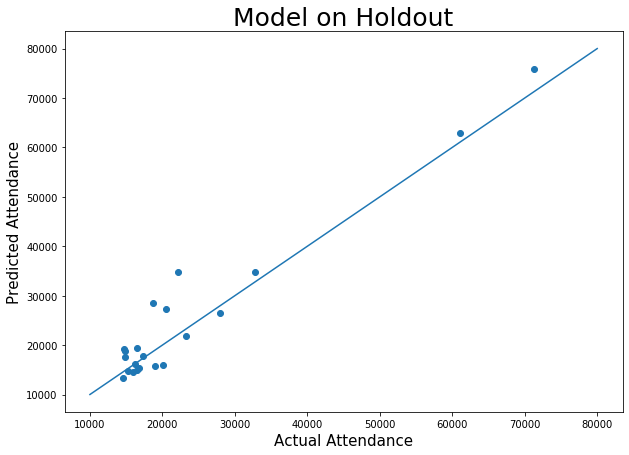

In [739]:
plt.figure(figsize=(10,7))
plt.scatter(y_test,lr.predict(X_test))
plt.title('Model on Holdout', fontsize=25)
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.plot([10000,80000],[10000,80000])
plt.savefig('final_test1.png')

In [675]:
fire

Capacity                     61500.000000
Founded                       1998.000000
Latitude                        41.863000
Longitude                      -87.617000
Games                           17.000000
2018winPCT                       0.470588
Dist_close_team_in_league      279.700000
Teams_within_1_mi                1.000000
Teams_within_10_mi               5.000000
Teams_within_25_mi               5.000000
Teams_within_50_mi               5.000000
pop2016                      50000.000000
pop_dens                     11883.000000
Sport_Basketball                 0.000000
Sport_Football                   0.000000
Sport_Hockey                     0.000000
Sport_Soccer                     1.000000
Name: Chicago Fire FC, dtype: float64

In [676]:
fire = fire.drop(drop_para)

In [677]:
lr.predict(np.array(fire).reshape(1,-1))

array([50035.99829541])

# Examine ratio of Attendance and Capacity

## First pass

In [749]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [750]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=49)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')

Simple regression scores:  [0.2697123847438353, 0.494963723122431, 0.5882342530713071, 0.6061330420861617, -0.334412296640179, -0.11647257116034226, -0.8370926521886168, -5.388706195693808, -0.44567516166857235, 0.39066359851291366]
Ridge scores:  [0.2509369412104143, 0.3311016276096216, 0.5745512082134392, 0.5926710617872029, -0.3757219236447804, -0.14740644721590757, -0.8774110943574207, -5.672082272681607, -0.29279962044350727, 0.4160339242478711]
Lasso scores:  [-0.06445206842998541, -0.24016948913884795, -0.04883718323372177, -0.03982118413854363, -0.7306319848834844, -0.0025352092357098233, -0.14375488863516273, -3.010679893550545, -0.19840948434816186, -0.0015051699458452639] 

Simple mean r^2: -0.477 +- 1.702
Ridge mean r^2: -0.520 +- 1.775
Lasso mean r^2: -0.448 +- 0.878

Simple mean rmse: 0.121 +- 0.035
Ridge mean rmse: 0.122 +- 0.031
Lasso mean rmse: 0.138 +- 0.035

Simple mean mae: 0.102 +- 0.030
Ridge mean mae: 0.103 +- 0.027
Lasso mean mae: 0.114 +- 0.022


#### Check Lasso

In [759]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-3,-1,200)
#alphavec = 10**np.linspace(1,2,200)
#alphavec = np.linspace(10,100,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 0.006080224261649427


/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016046819372939058, tolerance: 0.00014523099431973862
  tol, rng, random, positive)
/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016507063945492284, tolerance: 0.00013405076641138144
  tol, rng, random, positive)
/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001844549354420577, tolerance: 0.0001534556574490182
  tol, rng, random, positive)
/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

[('Capacity', -0.0),
 ('Founded', -0.031037138988133543),
 ('Latitude', 0.0),
 ('Longitude', -0.014054753975334433),
 ('Games', -0.07825383993888838),
 ('2018winPCT', 0.019588074765840284),
 ('Dist_close_team_in_league', 0.0),
 ('Teams_within_1_mi', -0.002154638301804089),
 ('Teams_within_10_mi', -0.0),
 ('Teams_within_25_mi', -0.0009659171704060534),
 ('Teams_within_50_mi', -0.0),
 ('pop2016', 0.0),
 ('pop_dens', 0.0),
 ('Sport_Basketball', 0.03496046339839712),
 ('Sport_Football', 0.0),
 ('Sport_Hockey', 0.03112673749152141),
 ('Sport_Soccer', -0.0116402288568429)]

##  Second pass

In [761]:
X_train = X_train_prime.copy()

In [762]:
drop_para = [
    'Capacity',
    #'Founded',
    'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    #'Teams_within_1_mi',
    'Teams_within_10_mi',
    #'Teams_within_25_mi',
    'Teams_within_50_mi',
    'pop2016',
    'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    #'Sport_Soccer'
]

In [763]:
X_train = X_train.drop(drop_para, axis=1)

In [764]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [767]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=.001)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')

Simple regression scores:  [0.30418149212693213, 0.33909339028857244, 0.6240261933913602, 0.5815854558648561, -0.59070150309448, 0.5727153330167132, 0.029715756479086308, -4.778702616418857, -0.06320480719515653, 0.5962314398251166]
Ridge scores:  [0.30418237130856096, 0.3391091962414563, 0.624019371966617, 0.5815706190147065, -0.5902655198624684, 0.5727833885605387, 0.02970673571863569, -4.778594276817834, -0.06319216608757694, 0.5961926074942887]
Lasso scores:  [0.2990628460812932, 0.34812614732509184, 0.6170879273300145, 0.5703100251716642, -0.48387855749977127, 0.5856665194689086, 0.045758324514622806, -4.662285970534971, -0.06706581006916856, 0.5853640474538787] 

Simple mean r^2: -0.239 +- 1.557
Ridge mean r^2: -0.238 +- 1.557
Lasso mean r^2: -0.216 +- 1.520

Simple mean rmse: 0.109 +- 0.030
Ridge mean rmse: 0.109 +- 0.030
Lasso mean rmse: 0.109 +- 0.030

Simple mean mae: 0.088 +- 0.028
Ridge mean mae: 0.088 +- 0.028
Lasso mean mae: 0.088 +- 0.028


#### Check Lasso

In [770]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-3,-1,200)
#alphavec = 10**np.linspace(1,2,200)
#alphavec = np.linspace(10,100,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 0.001096985797892384


[('Founded', -0.044206672803746176),
 ('Longitude', -0.019908398545680318),
 ('Games', -0.09031730670327862),
 ('2018winPCT', 0.02870167037480528),
 ('Teams_within_1_mi', -0.009846332775695427),
 ('Teams_within_25_mi', -0.0059554101771435485),
 ('Sport_Basketball', 0.04385319275115502),
 ('Sport_Hockey', 0.03751769685521615),
 ('Sport_Soccer', -0.010992432988478728)]

##  Third pass

In [771]:
X_train = X_train_prime.copy()

In [772]:
drop_para = [
    'Capacity',
    #'Founded',
    'Latitude',
    #'Longitude',
    #'Games',
    #'2018winPCT',
    'Dist_close_team_in_league',
    'Teams_within_1_mi',
    'Teams_within_10_mi',
    'Teams_within_25_mi',
    'Teams_within_50_mi',
    'pop2016',
    'pop_dens',
    #'Sport_Basketball',
    'Sport_Football',
    #'Sport_Hockey',
    #'Sport_Soccer'
]

In [773]:
X_train = X_train.drop(drop_para, axis=1)

In [774]:
kf = KFold(n_splits=10, shuffle=True, random_state = 20)

In [775]:
lr_r2 = []
ridge_r2 = []
lasso_r2 = []

lr_rmse = []
ridge_rmse = []
lasso_rmse = []

lr_mae = []
ridge_mae = []
lasso_mae = []

for tr, val in kf.split(X_train, y_train):

    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]

    #Setup regressions
    lr = LinearRegression()
    lr_ridge = Ridge(alpha=.00466)
    lr_lasso = Lasso(alpha=.001)

    lr.fit(X_tr, y_tr)

    lr_r2.append(r2_score(y_val, lr.predict(X_val)))
    lr_rmse.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
    lr_mae.append(mae(y_val, lr.predict(X_val)))

    #Standard scale for regulation
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    #Ridge Regulation
    lr_ridge.fit(X_tr_scaled, y_tr)

    ridge_r2.append(r2_score(y_val, lr_ridge.predict(X_val_scaled)))
    ridge_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_ridge.predict(X_val_scaled))))
    ridge_mae.append(mae(y_val, lr_ridge.predict(X_val_scaled)))
    
    #Lasso
    lr_lasso.fit(X_tr_scaled, y_tr)

    lasso_r2.append(r2_score(y_val, lr_lasso.predict(X_val_scaled)))
    lasso_rmse.append(
        np.sqrt(mean_squared_error(y_val, lr_lasso.predict(X_val_scaled))))
    lasso_mae.append(mae(y_val, lr_lasso.predict(X_val_scaled)))

print('Simple regression scores: ', lr_r2)
print('Ridge scores: ', ridge_r2)
print('Lasso scores: ', lasso_r2, '\n')

print(f'Simple mean r^2: {np.mean(lr_r2):.3f} +- {np.std(lr_r2):.3f}')
print(f'Ridge mean r^2: {np.mean(ridge_r2):.3f} +- {np.std(ridge_r2):.3f}')
print(f'Lasso mean r^2: {np.mean(lasso_r2):.3f} +- {np.std(lasso_r2):.3f}\n')

print(f'Simple mean rmse: {np.mean(lr_rmse):.3f} +- {np.std(lr_rmse):.3f}')
print(f'Ridge mean rmse: {np.mean(ridge_rmse):.3f} +- {np.std(ridge_rmse):.3f}')
print(f'Lasso mean rmse: {np.mean(lasso_rmse):.3f} +- {np.std(lasso_rmse):.3f}\n')

print(f'Simple mean mae: {np.mean(lr_mae):.3f} +- {np.std(lr_mae):.3f}')
print(f'Ridge mean mae: {np.mean(ridge_mae):.3f} +- {np.std(ridge_mae):.3f}')
print(f'Lasso mean mae: {np.mean(lasso_mae):.3f} +- {np.std(lasso_mae):.3f}')

Simple regression scores:  [0.30208016999065346, 0.4323330881198635, 0.5950363285937428, 0.5517702706079812, -0.3256127577670278, 0.6311378651956239, 0.061472867569864476, -4.4060283505268805, -0.003180427602835545, 0.6049083398296018]
Ridge scores:  [0.3020847700387643, 0.43234862291169607, 0.59504258723524, 0.5517602586583197, -0.32527232500955905, 0.6311836185313806, 0.061459806459967514, -4.405965051167746, -0.003176401217729774, 0.6048614439416522]
Lasso scores:  [0.2974421610012028, 0.43474066152219903, 0.5948869698474346, 0.5487183065972596, -0.25721308985813063, 0.6335538351858243, 0.06732120883195203, -4.3369442894540375, -0.007324949249331025, 0.588501882996852] 

Simple mean r^2: -0.156 +- 1.449
Ridge mean r^2: -0.156 +- 1.448
Lasso mean r^2: -0.144 +- 1.427

Simple mean rmse: 0.106 +- 0.030
Ridge mean rmse: 0.106 +- 0.030
Lasso mean rmse: 0.106 +- 0.030

Simple mean mae: 0.086 +- 0.029
Ridge mean mae: 0.086 +- 0.029
Lasso mean mae: 0.086 +- 0.029


#### Check Lasso

In [776]:
std = StandardScaler()
X_tr_sc = std.fit_transform(X_train.values)

alphavec = 10**np.linspace(-3,-1,200)
#alphavec = 10**np.linspace(1,2,200)
#alphavec = np.linspace(10,100,200)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_tr_sc, y_train)

print(f'alpha: {lasso_model.alpha_}')

list(zip(X_train.columns, lasso_model.coef_))

alpha: 0.001


[('Founded', -0.04298642613782933),
 ('Longitude', -0.02072066582800596),
 ('Games', -0.09169181301013556),
 ('2018winPCT', 0.026003417615562456),
 ('Sport_Basketball', 0.0421280323037011),
 ('Sport_Hockey', 0.03753283794685738),
 ('Sport_Soccer', -0.011914108651318693)]

# Statsmodels investigation

## AttendPCT 

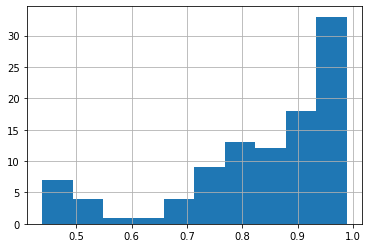

In [777]:
y.hist()

In [790]:
model = sm.OLS(y, sm.add_constant(X))
fit = model.fit()
fit.summary()

/Users/nkfoster/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AttendPCT   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     6.149
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           5.43e-09
Time:                        13:15:38   Log-Likelihood:                 91.443
No. Observations:                 102   AIC:                            -146.9
Df Residuals:                      84   BIC:                            -99.64
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6748      1.796     -0.376      0.708      -4.247       2.897
Capacity                  -3.475e-07   2.02e-06     -0.172      0.864   -4.36e-06    3.66e-06
Founded                      -0.0012      0.000     -2.961      0.004      -0.002      -0.000
Latitude                     -0.0025      0.003     -0.897      0.372      -0.008       0.003
Longitude                    -0.0015      0.001     -1.762      0.082      -0.003       0.000
Games                         0.0448      0.020      2.231      0.028       0.005       0.085
2018winPCT                    0.1960      0.099      1.982      0.051      -0.001       0.393
Dist_close_team_in_league -5.044e-05      0.000     -0.489      0.626      -0.000       0.000
Teams_within_1_mi            -0.0178      0.015     -1.149      0.254      -0.049       0.013
Teams_within_10_mi            0.0082      0.011      0.713      0.478      -0.015       0.031
Teams_within_25_mi            0.0016      0.013      0.124      0.901      -0.024       0.027
Teams_within_50_mi           -0.0092      0.011     -0.802      0.425      -0.032       0.014
pop2016                    3.519e-09   7.87e-09      0.447      0.656   -1.21e-08    1.92e-08
pop_dens                   1.382e-06   3.34e-06      0.414      0.680   -5.25e-06    8.02e-06
Sport_Basketball              2.0452      0.784      2.607      0.011       0.485       3.605
Sport_Football                3.5383      1.477      2.396      0.019       0.602       6.475
Sport_Hockey                  2.0347      0.785      2.592      0.011       0.474       3.596
Sport_Soccer                  3.0431      1.269      2.398      0.019       0.519       5.567
==============================================================================
Omnibus:                        3.430   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                3.264
Skew:                          -0.437   Prob(JB):                        0.196
Kurtosis:                       2.924   Cond. No.                     6.60e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.6e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

rmse:  0.09872335703002816
mae:  0.07722632716270608


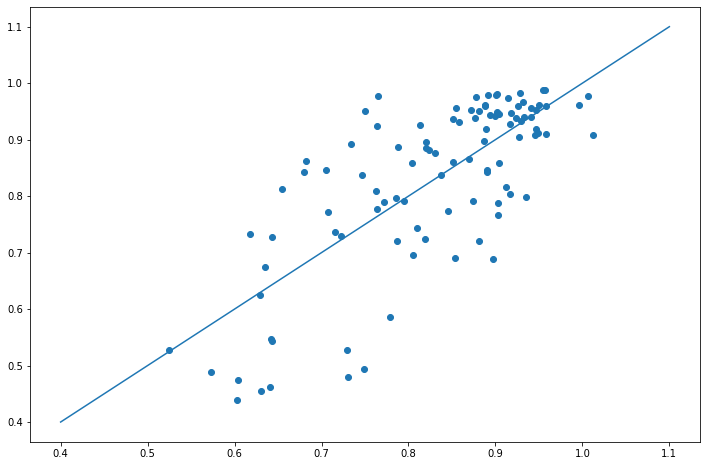

In [791]:
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), y);
plt.plot([0.4,1.1],[0.4,1.1])
print('rmse: ',rmse(y,fit.predict()))
print('mae: ',meanabs(y,fit.predict()))

#print('rmse: ',np.exp(rmse(y,fit.predict())))
#print('mae: ',np.exp(meanabs(y,fit.predict())))

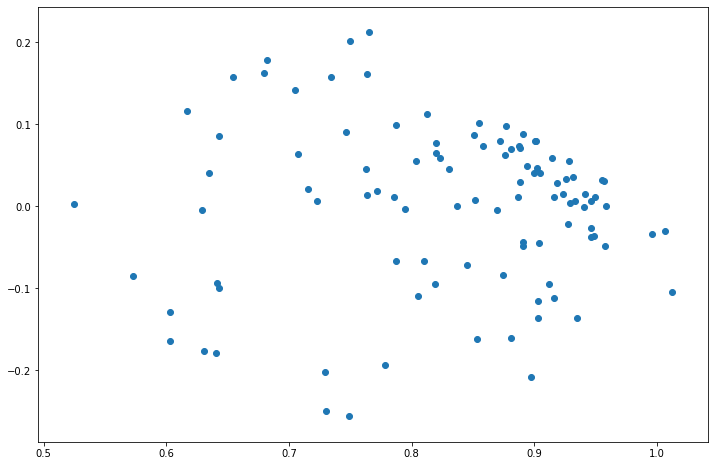

In [792]:
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

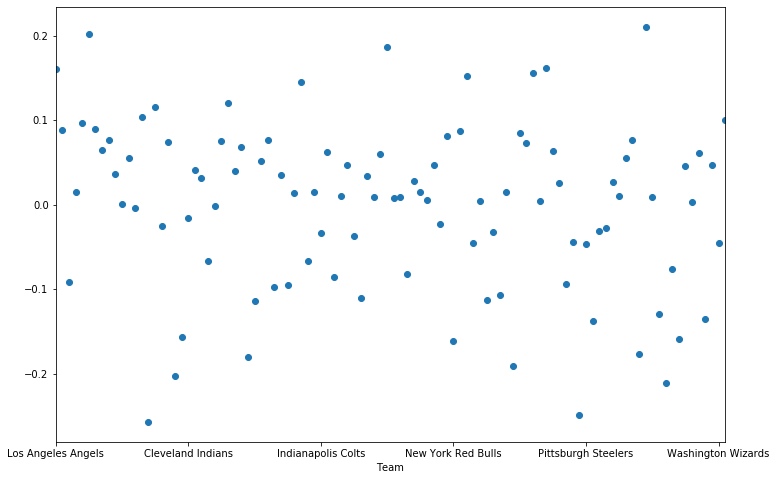

In [789]:
fit.resid.plot(style='o', figsize=(12,8));

### Second pass

In [793]:
model = sm.OLS(y, sm.add_constant(X.drop(['Capacity','Teams_within_25_mi'],axis=1)))
fit2 = model.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AttendPCT   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     7.125
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           7.63e-10
Time:                        13:18:41   Log-Likelihood:                 91.406
No. Observations:                 102   AIC:                            -150.8
Df Residuals:                      86   BIC:                            -108.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5903      1.741     -0.339      0.735      -4.051       2.870
Founded                      -0.0012      0.000     -2.996      0.004      -0.002      -0.000
Latitude                     -0.0025      0.003     -0.919      0.361      -0.008       0.003
Longitude                    -0.0015      0.001     -1.800      0.075      -0.003       0.000
Games                         0.0436      0.019      2.276      0.025       0.006       0.082
2018winPCT                    0.1975      0.098      2.025      0.046       0.004       0.391
Dist_close_team_in_league -5.048e-05   9.82e-05     -0.514      0.609      -0.000       0.000
Teams_within_1_mi            -0.0173      0.015     -1.144      0.256      -0.047       0.013
Teams_within_10_mi            0.0081      0.010      0.769      0.444      -0.013       0.029
Teams_within_50_mi           -0.0080      0.008     -1.016      0.312      -0.024       0.008
pop2016                    3.623e-09   7.71e-09      0.470      0.640   -1.17e-08    1.89e-08
pop_dens                   1.437e-06   3.22e-06      0.446      0.657   -4.97e-06    7.85e-06
Sport_Basketball              2.0061      0.758      2.646      0.010       0.499       3.513
Sport_Football                3.4421      1.396      2.466      0.016       0.668       6.216
Sport_Hockey                  1.9955      0.759      2.630      0.010       0.487       3.504
Sport_Soccer                  2.9742      1.220      2.438      0.017       0.549       5.399
==============================================================================
Omnibus:                        3.517   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.356
Skew:                          -0.443   Prob(JB):                        0.187
Kurtosis:                       2.922   Cond. No.                     6.41e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

rmse:  0.09875907131337937
mae:  0.07731702514697152


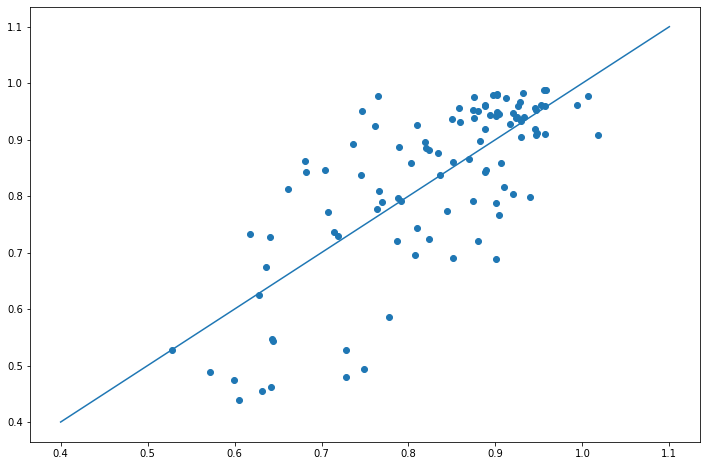

In [795]:
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), y);
plt.plot([0.4,1.1],[0.4,1.1])
print('rmse: ',rmse(y,fit2.predict()))
print('mae: ',meanabs(y,fit2.predict()))

### Third pass

In [796]:
model = sm.OLS(y, sm.add_constant(X.drop(['Capacity','Teams_within_25_mi','pop_dens','Dist_close_team_in_league','pop2016'],axis=1)))
fit3 = model.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AttendPCT   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     9.010
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           4.70e-11
Time:                        13:22:20   Log-Likelihood:                 90.767
No. Observations:                 102   AIC:                            -155.5
Df Residuals:                      89   BIC:                            -121.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3847      1.660     -0.232      0.817      -3.682       2.913
Founded               -0.0013      0.000     -3.183      0.002      -0.002      -0.000
Latitude              -0.0018      0.002     -0.748      0.456      -0.006       0.003
Longitude             -0.0012      0.001     -1.627      0.107      -0.003       0.000
Games                  0.0417      0.018      2.263      0.026       0.005       0.078
2018winPCT             0.1838      0.094      1.966      0.052      -0.002       0.370
Teams_within_1_mi     -0.0209      0.014     -1.450      0.151      -0.050       0.008
Teams_within_10_mi     0.0100      0.009      1.080      0.283      -0.008       0.028
Teams_within_50_mi    -0.0038      0.006     -0.645      0.520      -0.016       0.008
Sport_Basketball       1.9315      0.730      2.645      0.010       0.481       3.382
Sport_Football         3.3007      1.343      2.458      0.016       0.633       5.969
Sport_Hockey           1.9195      0.730      2.628      0.010       0.468       3.371
Sport_Soccer           2.8507      1.173      2.431      0.017       0.520       5.181
==============================================================================
Omnibus:                        3.698   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.434
Skew:                          -0.449   Prob(JB):                        0.180
Kurtosis:                       2.997   Cond. No.                     4.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

rmse:  0.09937950083051206
mae:  0.07795283360120954


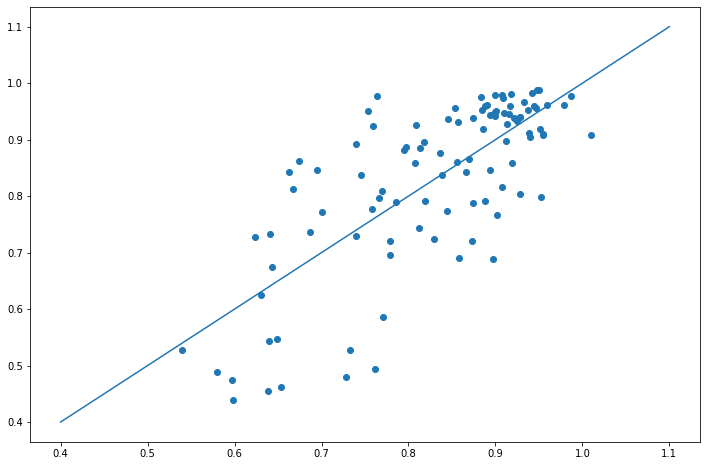

In [800]:
plt.figure(figsize=(12,8))
plt.scatter(fit3.predict(), y);
plt.plot([0.4,1.1],[0.4,1.1])
print('rmse: ',rmse(y,fit3.predict()))
print('mae: ',meanabs(y,fit3.predict()))

### Fourth

In [812]:
model = sm.OLS(
    y,
    sm.add_constant(
        X.drop([
            'Capacity', 
            'Teams_within_25_mi', 
            'pop_dens',
            'Dist_close_team_in_league', 
            'pop2016', 
            'Latitude',
            'Teams_within_50_mi'
        ],
               axis=1)))
fit4 = model.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AttendPCT   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     10.89
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           5.90e-12
Time:                        13:36:06   Log-Likelihood:                 90.347
No. Observations:                 102   AIC:                            -158.7
Df Residuals:                      91   BIC:                            -129.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.5652      1.630     -0.347      0.730      -3.804       2.673
Founded               -0.0012      0.000     -3.113      0.002      -0.002      -0.000
Longitude             -0.0011      0.001     -1.561      0.122      -0.002       0.000
Games                  0.0413      0.018      2.258      0.026       0.005       0.078
2018winPCT             0.1709      0.091      1.877      0.064      -0.010       0.352
Teams_within_1_mi     -0.0190      0.014     -1.349      0.181      -0.047       0.009
Teams_within_10_mi     0.0048      0.005      0.886      0.378      -0.006       0.016
Sport_Basketball       1.9151      0.725      2.643      0.010       0.476       3.355
Sport_Football         3.2716      1.333      2.455      0.016       0.624       5.919
Sport_Hockey           1.8990      0.725      2.621      0.010       0.460       3.338
Sport_Soccer           2.8170      1.164      2.421      0.017       0.506       5.128
==============================================================================
Omnibus:                        4.126   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.743
Skew:                          -0.467   Prob(JB):                        0.154
Kurtosis:                       3.088   Cond. No.                     4.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

rmse:  0.0997897544589183
mae:  0.07766068775626048


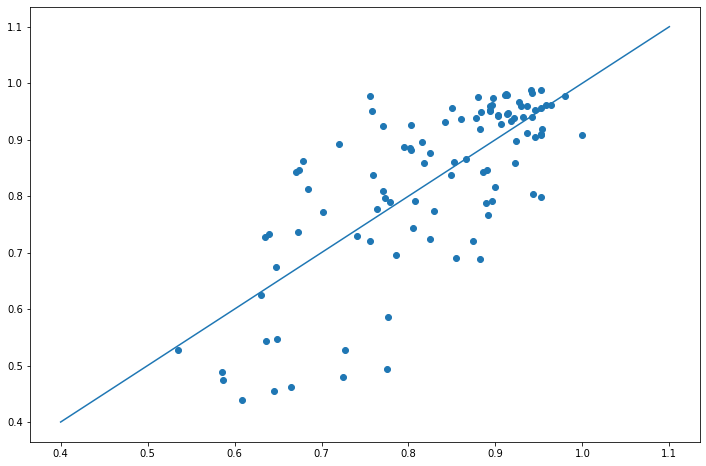

In [813]:
plt.figure(figsize=(12,8))
plt.scatter(fit4.predict(), y);
plt.plot([0.4,1.1],[0.4,1.1])
print('rmse: ',rmse(y,fit4.predict()))
print('mae: ',meanabs(y,fit4.predict()))

### Fifth

In [831]:
X2 = X.copy()

In [833]:
X2['log_Cap'] = np.log(X.Capacity)
X2['log_Long'] = np.log(-1*X.Longitude)
X2['sqrt_Dist'] = np.sqrt(X.Dist_close_team_in_league)

In [834]:
model = sm.OLS(
    y,
    sm.add_constant(
        X2.drop([
            'Capacity',
            #'Teams_within_1_mi',
            #'Teams_within_10_mi',
            'Teams_within_25_mi',
            'Teams_within_50_mi',
            'pop_dens',
            'pop2016',
            'Dist_close_team_in_league',
            'Latitude',
            #'Longitude'
        ], axis=1)))
fit5 = model.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AttendPCT   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     8.158
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           1.73e-10
Time:                        13:47:46   Log-Likelihood:                 90.545
No. Observations:                 102   AIC:                            -153.1
Df Residuals:                      88   BIC:                            -116.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.5482      4.732      0.327      0.744      -7.855      10.951
Founded               -0.0011      0.000     -2.935      0.004      -0.002      -0.000
Longitude             -0.0068      0.012     -0.570      0.570      -0.031       0.017
Games                  0.0412      0.020      2.089      0.040       0.002       0.080
2018winPCT             0.1696      0.094      1.805      0.074      -0.017       0.356
Teams_within_1_mi     -0.0177      0.015     -1.192      0.237      -0.047       0.012
Teams_within_10_mi     0.0040      0.006      0.617      0.539      -0.009       0.017
Sport_Basketball       1.8993      0.770      2.468      0.016       0.370       3.429
Sport_Football         3.2710      1.446      2.263      0.026       0.398       6.144
Sport_Hockey           1.8798      0.770      2.440      0.017       0.349       3.411
Sport_Soccer           2.7983      1.246      2.246      0.027       0.322       5.274
log_Cap               -0.0150      0.080     -0.188      0.851      -0.174       0.144
log_Long              -0.5586      1.156     -0.483      0.630      -2.856       1.739
sqrt_Dist           1.469e-05      0.003      0.006      0.995      -0.005       0.005
==============================================================================
Omnibus:                        4.078   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.676
Skew:                          -0.462   Prob(JB):                        0.159
Kurtosis:                       3.101   Cond. No.                     9.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

rmse:  0.09959611604758119
mae:  0.07764543684412288


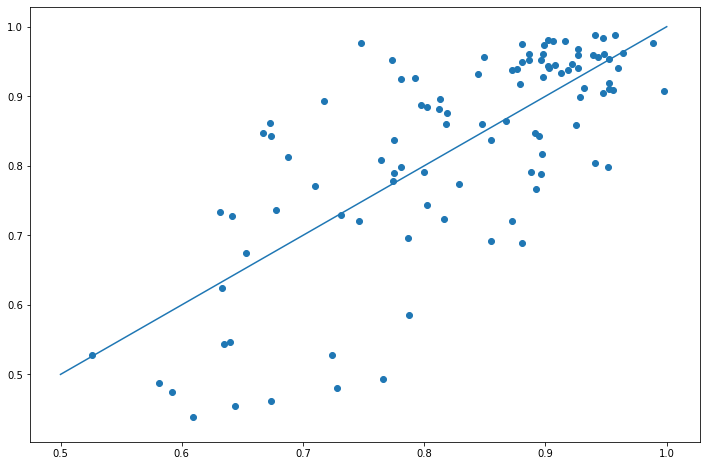

In [835]:
plt.figure(figsize=(12,8))
plt.scatter(fit5.predict(), y);
line = [.5,1]
plt.plot(line,line)
print('rmse: ',rmse(y,fit5.predict()))
print('mae: ',meanabs(y,fit5.predict()))